# 03: Train the Duckling

Train our tiny transformer on TinyStories, recording W at every step.

**Architecture:** GPT2LMHeadModel (8L/128D/2H, ~2.9M params)  
**Budget:** 10% Chinchilla (~5,700 steps)  
**Output:** `movies/W_movie.safetensors`

---

*Jeffery Harrell & Alpha, December 1, 2025*

## Parameters

In [13]:
import torch
from pathlib import Path

# Paths
TOKENIZER_PATH = Path("data/tokenizer")
CORPUS_PATH = Path("data/corpus/tokens.safetensors")
DEAD_TOKENS_PATH = Path("data/corpus/dead_tokens.safetensors")
MOVIE_PATH = Path("movies/W_movie.safetensors")

# Architecture (TinyStories recipe)
LIVE_VOCAB = 8_000      # From tokenizer
DEAD_VOCAB = 2_000      # Phantom tokens
TOTAL_VOCAB = 10_000    # Embedding matrix size
D_MODEL = 128
N_LAYERS = 8
N_HEADS = 2
D_FF = 512
SEQ_LEN = 512
DROPOUT = 0.0

# Training (Chinchilla-informed)
BATCH_SIZE = 16
LEARNING_RATE = 1e-4     # TinyStories used this
WEIGHT_DECAY = 0.01
CHINCHILLA_PCT = 0.10    # Start with 10%

# Precision
MODEL_DTYPE = torch.bfloat16

# Reproducibility
RANDOM_SEED = 42

In [14]:
# Calculate training budget
model_params = TOTAL_VOCAB * D_MODEL + SEQ_LEN * D_MODEL + N_LAYERS * (4 * D_MODEL**2 + 2 * D_MODEL * D_FF + 4 * D_MODEL)
chinchilla_tokens = 20 * model_params
target_tokens = int(chinchilla_tokens * CHINCHILLA_PCT)
tokens_per_step = BATCH_SIZE * SEQ_LEN
NUM_STEPS = target_tokens // tokens_per_step

print(f"Model params: ~{model_params:,}")
print(f"Chinchilla optimal: {chinchilla_tokens:,} tokens")
print(f"Target ({CHINCHILLA_PCT*100:.0f}%): {target_tokens:,} tokens")
print(f"Tokens per step: {tokens_per_step:,}")
print(f"Training steps: {NUM_STEPS:,}")

# Storage estimate
W_bytes = TOTAL_VOCAB * D_MODEL * 2  # bfloat16
movie_gb = (NUM_STEPS + 1) * W_bytes / 1e9
print(f"\nMovie storage: {movie_gb:.2f} GB")

Model params: ~2,922,496
Chinchilla optimal: 58,449,920 tokens
Target (10%): 5,844,992 tokens
Tokens per step: 8,192
Training steps: 713

Movie storage: 1.83 GB


## Setup

In [15]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from safetensors.torch import load_file, save_file
from transformers import GPT2Config, GPT2LMHeadModel
from tqdm.auto import tqdm
import time

torch.manual_seed(RANDOM_SEED)

# Device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Device: {device}")
print(f"Dtype: {MODEL_DTYPE}")

Device: mps
Dtype: torch.bfloat16


## Load Data

In [16]:
# Load corpus
corpus_data = load_file(CORPUS_PATH)
all_tokens = corpus_data["tokens"]
print(f"Corpus: {len(all_tokens):,} tokens")

# Load dead token info
dead_data = load_file(DEAD_TOKENS_PATH)
dead_mask = dead_data["dead_mask"]
print(f"Dead tokens: {dead_mask.sum().item():,}")

Corpus: 51,110,591 tokens
Dead tokens: 2,000


In [17]:
class TokenDataset(Dataset):
    """Simple dataset that samples random windows from the corpus."""
    def __init__(self, tokens, seq_len, num_samples):
        self.tokens = tokens
        self.seq_len = seq_len
        self.num_samples = num_samples
        self.max_start = len(tokens) - seq_len - 1
        # Pre-generate random starts
        self.starts = torch.randint(0, self.max_start, (num_samples,))
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        start = self.starts[idx]
        chunk = self.tokens[start:start + self.seq_len + 1]
        return chunk[:-1], chunk[1:]  # input, target

# Create dataset with enough samples for our training
num_samples = NUM_STEPS * BATCH_SIZE * 2  # 2x buffer
dataset = TokenDataset(all_tokens, SEQ_LEN, num_samples)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

print(f"Dataset samples: {len(dataset):,}")
print(f"Batches available: {len(loader):,}")

Dataset samples: 22,816
Batches available: 1,426


## Model

In [18]:
# Use HuggingFace GPT2LMHeadModel — proven to work in TinyStoriesTinker
config = GPT2Config(
    vocab_size=TOTAL_VOCAB,
    n_positions=SEQ_LEN,
    n_embd=D_MODEL,
    n_layer=N_LAYERS,
    n_head=N_HEADS,
    n_inner=D_FF,
    activation_function="gelu",
    resid_pdrop=DROPOUT,
    embd_pdrop=DROPOUT,
    attn_pdrop=DROPOUT,
    initializer_range=0.02,
    use_cache=False,
)

model = GPT2LMHeadModel(config).to(device).to(MODEL_DTYPE)

# Embedding matrix is at model.transformer.wte.weight
print(f"Embedding shape: {model.transformer.wte.weight.shape}")
n_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {n_params:,}")

Embedding shape: torch.Size([10000, 128])
Model parameters: 2,931,968


In [19]:
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

print(f"Optimizer: AdamW (lr={LEARNING_RATE}, wd={WEIGHT_DECAY})")

Optimizer: AdamW (lr=0.0001, wd=0.01)


## Training Loop

In [20]:
# Pre-allocate movie tensor
W_movie = torch.zeros(NUM_STEPS + 1, TOTAL_VOCAB, D_MODEL, dtype=torch.bfloat16)
losses = []

# Record initial state — note the different path for HuggingFace model
W_movie[0] = model.transformer.wte.weight.detach().cpu().to(torch.bfloat16)

print(f"W_movie shape: {W_movie.shape}")
print(f"W_movie size: {W_movie.numel() * 2 / 1e9:.2f} GB")

W_movie shape: torch.Size([714, 10000, 128])
W_movie size: 1.83 GB


In [21]:
model.train()
loader_iter = iter(loader)

print(f"Training for {NUM_STEPS:,} steps...")
print()

start_time = time.time()

for step in tqdm(range(1, NUM_STEPS + 1)):
    # Get batch
    try:
        x, y = next(loader_iter)
    except StopIteration:
        loader_iter = iter(loader)
        x, y = next(loader_iter)
    
    x, y = x.to(device), y.to(device)
    
    # Forward/backward — GPT2LMHeadModel computes loss for us when labels provided
    optimizer.zero_grad()
    outputs = model(x, labels=y)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    
    # Record
    losses.append(loss.item())
    W_movie[step] = model.transformer.wte.weight.detach().cpu().to(torch.bfloat16)
    
    # Progress
    if step % 200 == 0:
        elapsed = time.time() - start_time
        steps_per_sec = step / elapsed
        tqdm.write(f"Step {step:,}: loss={loss.item():.4f}, {steps_per_sec:.1f} steps/sec")

elapsed = time.time() - start_time
print()
print(f"Training done! {NUM_STEPS:,} steps in {elapsed:.1f}s ({NUM_STEPS/elapsed:.1f} steps/sec)")
print(f"Final loss: {losses[-1]:.4f}")

Training for 713 steps...



  0%|          | 0/713 [00:00<?, ?it/s]

Step 200: loss=6.7239, 9.2 steps/sec
Step 400: loss=6.2921, 9.4 steps/sec
Step 600: loss=6.1451, 9.5 steps/sec

Training done! 713 steps in 75.0s (9.5 steps/sec)
Final loss: 6.0914


## Save Movie

In [22]:
MOVIE_PATH.parent.mkdir(parents=True, exist_ok=True)

save_dict = {
    "W": W_movie,
    "losses": torch.tensor(losses, dtype=torch.float32),
    "dead_mask": dead_mask,
}

save_file(save_dict, MOVIE_PATH)

file_size = MOVIE_PATH.stat().st_size
print(f"Saved: {MOVIE_PATH}")
print(f"File size: {file_size / 1e9:.2f} GB")

Saved: movies/W_movie.safetensors
File size: 1.83 GB


## Quick Sanity Check

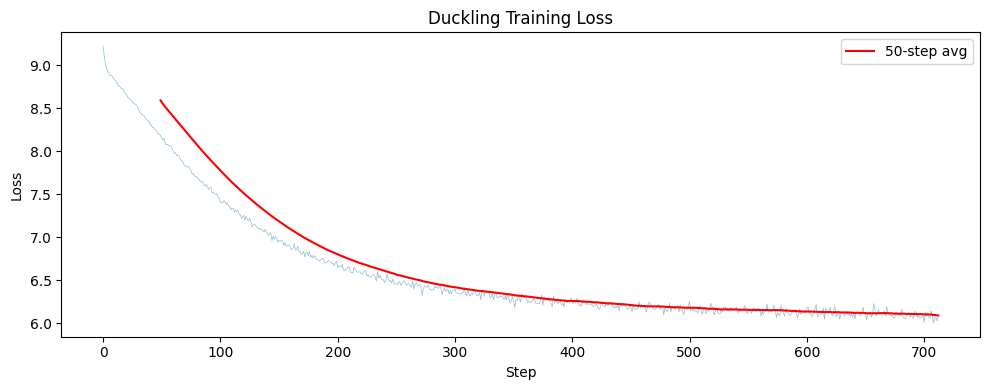


Initial loss: 9.2235
Final loss: 6.0914
Improvement: 3.1321


In [23]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(losses, alpha=0.5, linewidth=0.5)

# Smoothed version
window = 50
if len(losses) > window:
    smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')
    ax.plot(range(window-1, len(losses)), smoothed, 'r-', linewidth=1.5, label=f'{window}-step avg')

ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.set_title('Duckling Training Loss')
ax.legend()
plt.tight_layout()
plt.savefig('movies/loss_curve.png', dpi=150)
plt.show()

print(f"\nInitial loss: {losses[0]:.4f}")
print(f"Final loss: {losses[-1]:.4f}")
print(f"Improvement: {losses[0] - losses[-1]:.4f}")

## Summary

In [24]:
print("=" * 50)
print("DUCKLING TRAINING COMPLETE")
print("=" * 50)
print(f"Steps: {NUM_STEPS:,}")
print(f"Tokens seen: {NUM_STEPS * tokens_per_step:,}")
print(f"Time: {elapsed:.1f}s ({NUM_STEPS/elapsed:.1f} steps/sec)")
print(f"Initial loss: {losses[0]:.4f}")
print(f"Final loss: {losses[-1]:.4f}")
print(f"\nMovie: {MOVIE_PATH}")
print(f"Size: {file_size / 1e9:.2f} GB")

DUCKLING TRAINING COMPLETE
Steps: 713
Tokens seen: 5,840,896
Time: 75.0s (9.5 steps/sec)
Initial loss: 9.2235
Final loss: 6.0914

Movie: movies/W_movie.safetensors
Size: 1.83 GB
